<a href="https://colab.research.google.com/github/darthwaydr007/attention-experiments/blob/main/Attention_CIFAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import random
import torch.nn.init as init
#scaler = torch.cuda.amp.GradScaler() 
torch.backends.cudnn.benchmark = True
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU available.' % torch.cuda.device_count())
    print('GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU')
    device = torch.device("cpu")

There are 1 GPU available.
GPU: Tesla V100-SXM2-16GB


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

## Parameters

In [ ]:
manualSeed = 42
random.seed(manualSeed)
torch.manual_seed(manualSeed)

In [ ]:
BATCH_SIZE = 64
nc = 3
nz = 100
ngf = 32
ndf = 32
LR = 2e-3
img_dim = 32
CLASSES = 10
epsilon = 0.1
steps = 10

## Data

In [ ]:
transform=transforms.Compose([
                               #transforms.Resize(img_dim),
                               
                               #transforms.RandomHorizontalFlip(p=0.5),
                               #transforms.RandomCrop(32, padding=4),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),

                           ])

mnist_train = datasets.CIFAR10(root='/content/drive/My Drive/MNIST', train=True, download=True, transform=transform)
mnist_test = datasets.CIFAR10(root='/content/drive/My Drive/MNIST', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(mnist_train , batch_size = BATCH_SIZE, shuffle = True , drop_last=True,num_workers=10)
test_loader = torch.utils.data.DataLoader(mnist_test , batch_size = BATCH_SIZE , shuffle = False , drop_last=True,num_workers=10)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
def display_grid(images):
    grid_img = torchvision.utils.make_grid(images , nrow=16)
    npimgs = grid_img.cpu().detach().numpy()
    npimgs = npimgs*0.5+0.5
    plt.figure(figsize=(16,16))
    plt.imshow(np.transpose(npimgs, (1,2,0)), cmap='gray')
    plt.show()

In [ ]:
#display_grid(images)

## Model

In [ ]:
class AugmentedConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dk, dv, Nh, shape=0, relative=False, stride=1):
        super(AugmentedConv, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.dk = dk
        self.dv = dv
        self.Nh = Nh
        self.shape = shape
        self.relative = relative
        self.stride = stride
        self.padding = (self.kernel_size - 1) // 2

        assert self.Nh != 0, "integer division or modulo by zero, Nh >= 1"
        assert self.dk % self.Nh == 0, "dk should be divided by Nh. (example: out_channels: 20, dk: 40, Nh: 4)"
        assert self.dv % self.Nh == 0, "dv should be divided by Nh. (example: out_channels: 20, dv: 4, Nh: 4)"
        assert stride in [1, 2], str(stride) + " Up to 2 strides are allowed."

        self.conv_out = nn.Conv2d(self.in_channels, self.out_channels - self.dv, self.kernel_size, stride=stride, padding=self.padding)

        self.qkv_conv = nn.Conv2d(self.in_channels, 2 * self.dk + self.dv, kernel_size=self.kernel_size, stride=stride, padding=self.padding)

        self.attn_out = nn.Conv2d(self.dv, self.dv, kernel_size=1, stride=1)

        if self.relative:
            self.key_rel_w = nn.Parameter(torch.randn((2 * self.shape - 1, dk // Nh), requires_grad=True))
            self.key_rel_h = nn.Parameter(torch.randn((2 * self.shape - 1, dk // Nh), requires_grad=True))

    def forward(self, x):
        # Input x
        # (batch_size, channels, height, width)
        # batch, _, height, width = x.size()

        # conv_out
        # (batch_size, out_channels, height, width)
        conv_out = self.conv_out(x)
        batch, _, height, width = conv_out.size()

        # flat_q, flat_k, flat_v
        # (batch_size, Nh, height * width, dvh or dkh)
        # dvh = dv / Nh, dkh = dk / Nh
        # q, k, v
        # (batch_size, Nh, height, width, dv or dk)
        flat_q, flat_k, flat_v, q, k, v = self.compute_flat_qkv(x, self.dk, self.dv, self.Nh)
        logits = torch.matmul(flat_q.transpose(2, 3), flat_k)
        if self.relative:
            h_rel_logits, w_rel_logits = self.relative_logits(q)
            logits += h_rel_logits
            logits += w_rel_logits
        weights = F.softmax(logits, dim=-1)

        # attn_out
        # (batch, Nh, height * width, dvh)
        attn_out = torch.matmul(weights, flat_v.transpose(2, 3))
        attn_out = torch.reshape(attn_out, (batch, self.Nh, self.dv // self.Nh, height, width))
        # combine_heads_2d
        # (batch, out_channels, height, width)
        attn_out = self.combine_heads_2d(attn_out)
        attn_out = self.attn_out(attn_out)
        return torch.cat((conv_out, attn_out), dim=1)

    def compute_flat_qkv(self, x, dk, dv, Nh):
        qkv = self.qkv_conv(x)
        N, _, H, W = qkv.size()
        q, k, v = torch.split(qkv, [dk, dk, dv], dim=1)
        q = self.split_heads_2d(q, Nh)
        k = self.split_heads_2d(k, Nh)
        v = self.split_heads_2d(v, Nh)

        dkh = dk // Nh
        q *= dkh ** -0.5
        flat_q = torch.reshape(q, (N, Nh, dk // Nh, H * W))
        flat_k = torch.reshape(k, (N, Nh, dk // Nh, H * W))
        flat_v = torch.reshape(v, (N, Nh, dv // Nh, H * W))
        return flat_q, flat_k, flat_v, q, k, v

    def split_heads_2d(self, x, Nh):
        batch, channels, height, width = x.size()
        ret_shape = (batch, Nh, channels // Nh, height, width)
        split = torch.reshape(x, ret_shape)
        return split

    def combine_heads_2d(self, x):
        batch, Nh, dv, H, W = x.size()
        ret_shape = (batch, Nh * dv, H, W)
        return torch.reshape(x, ret_shape)

    def relative_logits(self, q):
        B, Nh, dk, H, W = q.size()
        q = torch.transpose(q, 2, 4).transpose(2, 3)

        rel_logits_w = self.relative_logits_1d(q, self.key_rel_w, H, W, Nh, "w")
        rel_logits_h = self.relative_logits_1d(torch.transpose(q, 2, 3), self.key_rel_h, W, H, Nh, "h")

        return rel_logits_h, rel_logits_w

    def relative_logits_1d(self, q, rel_k, H, W, Nh, case):
        rel_logits = torch.einsum('bhxyd,md->bhxym', q, rel_k)
        rel_logits = torch.reshape(rel_logits, (-1, Nh * H, W, 2 * W - 1))
        rel_logits = self.rel_to_abs(rel_logits)

        rel_logits = torch.reshape(rel_logits, (-1, Nh, H, W, W))
        rel_logits = torch.unsqueeze(rel_logits, dim=3)
        rel_logits = rel_logits.repeat((1, 1, 1, H, 1, 1))

        if case == "w":
            rel_logits = torch.transpose(rel_logits, 3, 4)
        elif case == "h":
            rel_logits = torch.transpose(rel_logits, 2, 4).transpose(4, 5).transpose(3, 5)
        rel_logits = torch.reshape(rel_logits, (-1, Nh, H * W, H * W))
        return rel_logits

    def rel_to_abs(self, x):
        B, Nh, L, _ = x.size()

        col_pad = torch.zeros((B, Nh, L, 1)).to(x)
        x = torch.cat((x, col_pad), dim=3)

        flat_x = torch.reshape(x, (B, Nh, L * 2 * L))
        flat_pad = torch.zeros((B, Nh, L - 1)).to(x)
        flat_x_padded = torch.cat((flat_x, flat_pad), dim=2)

        final_x = torch.reshape(flat_x_padded, (B, Nh, L + 1, 2 * L - 1))
        final_x = final_x[:, :, :L, L - 1:]
        return final_x

In [ ]:
class AttentionConv2d(nn.Module):
    def __init__(self, input_dim, output_dim, dk, dv, num_heads, kernel_size, padding, rel_encoding=True, height=None, width=None):
        super(AttentionConv2d, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.dk = dk
        self.dv = dv
        self.num_heads = num_heads
        self.kernel_size = kernel_size
        self.dkh = self.dk // self.num_heads
        if rel_encoding and not height:
            raise("Cannot use relative encoding without specifying input's height and width")
        self.H = height
        self.W = width

        self.conv_qkv = nn.Conv2d(input_dim, 2*dk + dv, 1)
        self.conv_attn = nn.Conv2d(dv, dv, 1)
        self.conv_out = nn.Conv2d(input_dim, output_dim - dv, kernel_size, padding=padding)
        self.softmax = nn.Softmax(dim=-1)
        print("dkh:",self.dkh)
        print("dkh:",self.dkh)
        print("dkh:",self.dkh)

        self.key_rel_w = nn.Parameter(self.dkh**-0.5 + torch.rand(2*width-1, self.dkh), requires_grad=True)
        self.key_rel_h = nn.Parameter(self.dkh**-0.5 + torch.rand(2*height-1, self.dkh), requires_grad=True)
        self.relative_encoding = rel_encoding
        

    def forward(self, input):
        conv_out = self.conv_out(input)

        qkv = self.conv_qkv(input)    # batch_size, 2*dk+dv, H, W
        
        q, k, v = torch.split(qkv, [self.dk, self.dk, self.dv], dim=1)
        
        batch_size, _, H, W = q.size()

        q = q.view([batch_size, self.num_heads, self.dk // self.num_heads, H*W])
        k = k.view([batch_size, self.num_heads, self.dk // self.num_heads, H*W])
        v = v.view([batch_size, self.num_heads, self.dv // self.num_heads, H*W])

        q *= self.dkh ** -0.5
        logits = einsum('ijkl, ijkm -> ijlm', q, k)
        if self.relative_encoding:
            h_rel_logits, w_rel_logits = self._relative_logits(q)
            logits += h_rel_logits
            logits += w_rel_logits

        weights = self.softmax(logits)
        attn_out = einsum('ijkl, ijfl -> ijfk', weights, v)
        attn_out = attn_out.contiguous().view(batch_size, self.dv, H, W)
        attn_out = self.conv_attn(attn_out)
        output = torch.cat([conv_out, attn_out], dim=1)
        return output

    def _relative_logits(self, q):
        b, nh, dkh, _ = q.size()
        q = q.view(b, nh, dkh, self.H, self.W)

        rel_logits_w = self._relative_logits1d(q, self.key_rel_w, self.H, self.W, nh, [0, 1, 2, 4, 3, 5])
        rel_logits_h = self._relative_logits1d(q.permute(0, 1, 2, 4, 3), self.key_rel_h, self.W, self.H, nh, [0, 1, 4, 2, 5, 3])
        return rel_logits_h, rel_logits_w

    def _relative_logits1d(self, q, rel_k, H, W, Nh, transpose_mask):
        rel_logits = einsum('bhdxy, md -> bhxym', q, rel_k)

        rel_logits = rel_logits.view([-1, Nh*H, W, 2*W-1])
        rel_logits = self._rel_to_abs(rel_logits)
        rel_logits = rel_logits.view([-1, Nh, H, W, W]).unsqueeze(dim=3).repeat([1,1,1,H,1,1])
        rel_logits = rel_logits.permute(*transpose_mask)
        rel_logits = rel_logits.contiguous().view(-1, Nh, H*W, H*W)
        return rel_logits

    def _rel_to_abs(self, x):
        b, nh, l, _ = x.size()


        x = F.pad(x, (0,1), 'constant', 0)
        flat_x = x.view([b, nh, l*(2*l)]);
        flat_x_padded = F.pad(flat_x, (0, l-1), 'constant', 0)

        final_x = flat_x_padded.view([b, nh, l+1, 2*l-1])
        final_x = final_x[:, :, :l, l-1:]

        return final_x

In [ ]:
# Example Code
tmp = torch.randn((16, 3, 32, 32)).to(device)
#layer1 = AttentionConv2d(input_dim=3, output_dim=20, dk=20, dv =4, num_heads = 4, kernel_size =3 , padding = 1,rel_encoding=False).to(device)
layer2 = AugmentedConv(in_channels=3, out_channels=ndf, kernel_size=3, dk=40, dv=4, Nh=4, relative=True,stride=1, shape=32).to(device)
layer3 = nn.Conv2d(3, ndf, kernel_size = 3,stride = 1, padding = 1).to(device)
#out1 = layer1(tmp)
out2 = layer2(tmp)
out3 = layer3(tmp)
#print(out1.shape)
print(out2.shape)
print(out3.shape)
# for name, param in augmented_conv1.named_parameters():
#     print('parameter name: ', name)
#
# augmented_conv2 = AugmentedConv(in_channels=3, out_channels=20, kernel_size=3, dk=40, dv=4, Nh=4, relative=True, padding=1, stride=1, shape=32).to(device)
# conv_out2 = augmented_conv2(tmp)
# print(conv_out2.shape)

torch.Size([16, 32, 32, 32])
torch.Size([16, 32, 32, 32])


In [ ]:
class Cifar10ClassifierAttention(nn.Module):
    def __init__(self,):
        super().__init__()
        self.model_head = nn.Sequential(
            # input is (nc) x 32 x 32
            AugmentedConv(in_channels=nc, out_channels=ndf, kernel_size=3, dk=40, dv=4, Nh=4, relative=True,stride=1, shape=32),
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            AugmentedConv(in_channels=ndf, out_channels=ndf*2, kernel_size=3, dk=40, dv=4, Nh=4, relative=True,stride=1, shape=32),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2)),
            # state size. (ndf*2) x 16 x 16
            AugmentedConv(in_channels=ndf*2, out_channels=ndf*4, kernel_size=3, dk=40, dv=4, Nh=4, relative=True,stride=1, shape=16),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 16 x 16
            AugmentedConv(in_channels=ndf*4, out_channels=ndf*8, kernel_size=3, dk=40, dv=4, Nh=4, relative=True,stride=1, shape=16),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2))
        )
            # state size. (ndf*8) x 8 x 8


        #)

        self.classes = nn.Sequential(
            nn.Linear(ndf*8*8*8,ndf*24),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(ndf*24,ndf*12),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(ndf*12,CLASSES),
            nn.LogSoftmax()
        )
    def forward(self, input):
          out = self.model_head(input)
          flatten = out.view(-1 , ndf*8*8*8)
          classes = self.classes(flatten)
          return classes.cuda()

In [ ]:
'''
            nn.Conv2d(ndf * 8, ndf*12, kernel_size = 3,stride = 1, padding = 1, bias=False),
            nn.BatchNorm2d(ndf*12),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*12) x 16 x 16
            nn.Conv2d(ndf*12, ndf * 16, kernel_size = 3,stride = 1, padding = 1, bias=False),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2)),
            # state size. (ndf*16) x 4 x 4
            nn.Conv2d(ndf * 16, ndf*24, kernel_size = 3,stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ndf*24),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*24) x 2 x 2
            '''

'\n            nn.Conv2d(ndf * 8, ndf*12, kernel_size = 3,stride = 1, padding = 1, bias=False),\n            nn.BatchNorm2d(ndf*12),\n            nn.LeakyReLU(0.2, inplace=True),\n            # state size. (ndf*12) x 16 x 16\n            nn.Conv2d(ndf*12, ndf * 16, kernel_size = 3,stride = 1, padding = 1, bias=False),\n            nn.BatchNorm2d(ndf * 16),\n            nn.LeakyReLU(0.2, inplace=True),\n            nn.MaxPool2d(kernel_size=(2, 2)),\n            # state size. (ndf*16) x 4 x 4\n            nn.Conv2d(ndf * 16, ndf*24, kernel_size = 3,stride = 2, padding = 1, bias=False),\n            nn.BatchNorm2d(ndf*24),\n            nn.LeakyReLU(0.2, inplace=True),\n            # state size. (ndf*24) x 2 x 2\n            '

In [ ]:
#model = Cifar10ClassifierAttention().to(device)
#tmp = torch.randn((16, nc, 32, 32)).to(device)
#out = model(tmp)
#out.shape

In [ ]:
class Cifar10Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model_head = nn.Sequential(
            # input is (nc) x 32 x 32
            nn.Conv2d(nc, ndf, kernel_size = 3,stride = 1, padding = 1, bias=False),
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, kernel_size = 3,stride = 1, padding = 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2)),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf*4, kernel_size = 3,stride = 1, padding = 1, bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 16 x 16
            nn.Conv2d(ndf*4, ndf * 8, kernel_size = 3,stride = 1, padding = 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2))
            # state size. (ndf*8) x 8 x 8
        )

        self.classes = nn.Sequential(
            nn.Linear(ndf*8*8*8,ndf*24),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(ndf*24,ndf*12),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(ndf*12,CLASSES),
            nn.LogSoftmax()
        )
    def forward(self, input):
          out = self.model_head(input)
          flatten = out.view(-1 , ndf*8*8*8)
          classes = self.classes(flatten)
          return classes.cuda()
    

In [ ]:
def weight_init(m):
    if isinstance(m, nn.Conv1d):
        init.normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.Conv2d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.Conv3d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.ConvTranspose1d):
        init.normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.ConvTranspose2d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.ConvTranspose3d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.BatchNorm1d):
        init.normal_(m.weight.data, mean=1, std=0.02)
        init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm2d):
        init.normal_(m.weight.data, mean=1, std=0.02)
        init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm3d):
        init.normal_(m.weight.data, mean=1, std=0.02)
        init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        init.xavier_normal_(m.weight.data)
        init.normal_(m.bias.data)

## Optimizer and Loss

In [ ]:
#criterion_disc = nn.BCEWithLogitsLoss()

In [ ]:
criterion_aux = nn.NLLLoss()
classifier_attention = Cifar10ClassifierAttention().to(device)
classifier = Cifar10Classifier().to(device)
#classifier.apply(weight_init)

In [ ]:
LR = 2e-3

In [ ]:
optim_claf = optim.SGD(classifier.parameters(), lr=LR,momentum=0.9) #optim.Adam(classifier.parameters(), lr=LR, betas=(0.5, 0.999))
optim_claf_attn = optim.SGD(classifier_attention.parameters(), lr=LR,momentum=0.9) #optim.Adam(classifier_attention.parameters(), lr=LR, betas=(0.5, 0.999))

In [ ]:
n_epoch = 10

In [ ]:
#scheduler_claf = torch.optim.lr_scheduler.OneCycleLR(optim_claf, max_lr= LR, steps_per_epoch=len(train_loader), epochs=n_epoch)
#scheduler_claf_attn = torch.optim.lr_scheduler.OneCycleLR(optim_claf_attn, max_lr= LR, steps_per_epoch=len(train_loader), epochs=n_epoch)
#scheduler_claf = torch.optim.lr_scheduler.OneCycleLR(optimizer_claf, max_lr= LR, steps_per_epoch=len(train_loader), epochs=n_epoch)

In [ ]:
Accuracy_Clasf_train = []
Accuracy_Clasf_test = []
loss_claf = []

In [ ]:
Accuracy_Clasf_train_attn = []
Accuracy_Clasf_test_attn = []
loss_claf = []

## Training

In [ ]:
#LR = 2e-3
#optimizer = optim.Adam(classifier.parameters(), lr = LR, betas=(0.5, 0.999))
scaler = torch.cuda.amp.GradScaler()
for epoch in range(0, n_epoch): 
   # if epoch % 5 == 0:
   #   LR = LR/2
   #   optimizer = optim.Adam(classifier.parameters(), lr = LR, betas=(0.5, 0.999))
    #epochs.append(epoch)
    #=======================Train=======================#
    classifier.train()
    correct = 0
    total = 0
    print('======== Epoch {:} / {:} ========'.format(epoch+1, n_epoch))          
    #D_losses, G_losses = [], []
    for batch_idx, (x, label) in enumerate(train_loader):
      
        optim_claf.zero_grad()
        #classifier.zero_grad()
        img = x.view(BATCH_SIZE, nc, img_dim, img_dim).cuda()
        
        with torch.cuda.amp.autocast(): 
          output = classifier(img)
          loss = criterion_aux(output , label.cuda())
        #loss.backward()
        scaler.scale(loss).backward() 
        
        #optimizer.step()
        scaler.step(optim_claf) 
        scaler.update()
        #scheduler_claf.step()
         
        new_loss = loss.item()
        #loss_claf.append(new_loss)

        for idx ,i in enumerate(output):
          if torch.argmax(i) == label[idx]:
            correct += 1
          total += 1

        if batch_idx % 200 == 0 and not batch_idx == 0: 
          #g_images = new_img.resize(BATCH_SIZE,nc,img_dim,img_dim)
          #display_grid(g_images)
          print('|| loss : {:} '.format(loss.mean().item())) 

    Accuracy_Clasf_train.append(correct/total)
    print('Accuracy Training regular: ' , round(correct/total , 4))
    #=======================Test=======================#    
    correct = 0
    total = 0
    classifier.eval()
    with torch.cuda.amp.autocast():
      with torch.no_grad():
        for batch_idx, (x, label) in enumerate(test_loader):
          x_real = x.view(BATCH_SIZE, nc, img_dim, img_dim).cuda()
          output = classifier(x_real)
          for idx ,i in enumerate(output):
            if torch.argmax(i) == label[idx]:
              correct += 1
            total += 1
    Accuracy_Clasf_test.append(correct/total)
    print('Accuracy Testing : ' , round(correct/total , 4))
    
    

======== Epoch 1 / 10 ========


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


|| loss : 1.1324152946472168 
|| loss : 1.13309645652771 
|| loss : 1.116385579109192 
Accuracy Training regular:  0.5642
Accuracy Testing :  0.6548
======== Epoch 2 / 10 ========
|| loss : 1.0561479330062866 
|| loss : 0.9855342507362366 
|| loss : 0.7093148827552795 
Accuracy Training regular:  0.7024
Accuracy Testing :  0.7056
======== Epoch 3 / 10 ========
|| loss : 0.7746318578720093 
|| loss : 0.6657141447067261 
|| loss : 0.7588242292404175 
Accuracy Training regular:  0.7552
Accuracy Testing :  0.7448
======== Epoch 4 / 10 ========
|| loss : 0.6162044405937195 
|| loss : 0.6836904287338257 
|| loss : 0.5231996178627014 
Accuracy Training regular:  0.7943
Accuracy Testing :  0.7526
======== Epoch 5 / 10 ========
|| loss : 0.507188081741333 
|| loss : 0.3656005263328552 
|| loss : 0.4070948660373688 
Accuracy Training regular:  0.8261
Accuracy Testing :  0.7555
======== Epoch 6 / 10 ========
|| loss : 0.5347079038619995 
|| loss : 0.41553881764411926 
|| loss : 0.4187140464782715

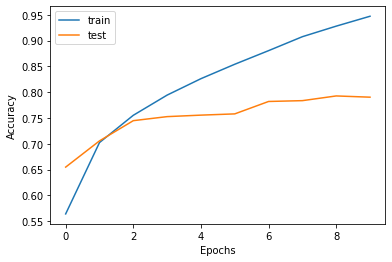

In [ ]:
x1 = Accuracy_Clasf_train
x2 = Accuracy_Clasf_test

plt.plot(x1  , label = 'train')
plt.plot(x2  ,  label = 'test')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
torch.cuda.memory_summary(device=None, abbreviated=False)
torch.cuda.empty_cache()

In [ ]:
#LR = 2e-3
#optimizer = optim.Adam(classifier.parameters(), lr = LR, betas=(0.5, 0.999))
scaler = torch.cuda.amp.GradScaler()
for epoch in range(0, n_epoch): 
   # if epoch % 5 == 0:
   #   LR = LR/2
   #   optimizer = optim.Adam(classifier.parameters(), lr = LR, betas=(0.5, 0.999))
    #epochs.append(epoch)
    #=======================Train=======================#
    classifier_attention.train()
    correct = 0
    total = 0
    print('======== Epoch {:} / {:} ========'.format(epoch+1, n_epoch))          
    #D_losses, G_losses = [], []
    for batch_idx, (x, label) in enumerate(train_loader):
      
        optim_claf_attn.zero_grad()
        #classifier_attention.zero_grad()
        img = x.view(BATCH_SIZE, nc, img_dim, img_dim).cuda()
        
        with torch.cuda.amp.autocast(): 
          output = classifier_attention(img)
          loss = criterion_aux(output , label.cuda())
        #loss.backward()
        scaler.scale(loss).backward() 
        
        #optimizer.step()
        scaler.step(optim_claf_attn) 
        scaler.update()
        #scheduler_claf_attn.step()
         
        new_loss = loss.item()
        #loss_claf.append(new_loss)

        for idx ,i in enumerate(output):
          if torch.argmax(i) == label[idx]:
            correct += 1
          total += 1

        if batch_idx % 200 == 0 and not batch_idx == 0: 
          #g_images = new_img.resize(BATCH_SIZE,nc,img_dim,img_dim)
          #display_grid(g_images)
          print('|| loss : {:} '.format(loss.mean().item())) 

    Accuracy_Clasf_train_attn.append(correct/total)
    print('Accuracy Training regular: ' , round(correct/total , 4))
    #=======================Test=======================#    
    correct = 0
    total = 0
    classifier_attention.eval()
    with torch.cuda.amp.autocast():
      with torch.no_grad():
        for batch_idx, (x, label) in enumerate(test_loader):
          x_real = x.view(BATCH_SIZE, nc, img_dim, img_dim).cuda()
          output = classifier_attention(x_real)
          for idx ,i in enumerate(output):
            if torch.argmax(i) == label[idx]:
              correct += 1
            total += 1
    Accuracy_Clasf_test_attn.append(correct/total)
    print('Accuracy Testing : ' , round(correct/total , 4))
    
    

======== Epoch 1 / 10 ========


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


|| loss : 1.374053716659546 
|| loss : 1.3507905006408691 
|| loss : 0.8516800403594971 
Accuracy Training regular:  0.5386
Accuracy Testing :  0.6365
======== Epoch 2 / 10 ========
|| loss : 1.0489082336425781 
|| loss : 0.879479169845581 
|| loss : 0.8156833052635193 
Accuracy Training regular:  0.6912
Accuracy Testing :  0.7089
======== Epoch 3 / 10 ========
|| loss : 0.7118626832962036 
|| loss : 0.8409357666969299 
|| loss : 0.8304343223571777 
Accuracy Training regular:  0.7472
Accuracy Testing :  0.7283
======== Epoch 4 / 10 ========
|| loss : 0.513823390007019 
|| loss : 0.5943735241889954 
|| loss : 0.7702941298484802 
Accuracy Training regular:  0.7863
Accuracy Testing :  0.7416
======== Epoch 5 / 10 ========
|| loss : 0.5245066285133362 
|| loss : 0.6253108382225037 
|| loss : 0.42211267352104187 
Accuracy Training regular:  0.8222
Accuracy Testing :  0.7629
======== Epoch 6 / 10 ========
|| loss : 0.341495156288147 
|| loss : 0.310931921005249 
|| loss : 0.39867717027664185

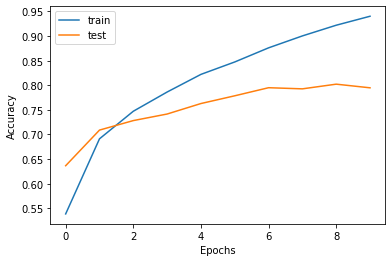

In [ ]:
x1 = Accuracy_Clasf_train_attn
x2 = Accuracy_Clasf_test_attn

plt.plot(x1  , label = 'train')
plt.plot(x2  ,  label = 'test')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
#import pickle
#pkl_filenam_claf   = "/content/drive/My Drive/pytorch/classifier-T4.pkl"
#pkl_filenam_gen   = "/content/drive/My Drive/pytorch/generator-T4.pkl"
#pkl_filenam_disc = "/content/drive/My Drive/pytorch/discriminator-T4.pkl"
#with open(pkl_filenam_claf, 'wb') as file:  
#    pickle.dump(classifier, file)
#
#with open(pkl_filenam_disc, 'wb') as file:  
#    pickle.dump(D, file)
#with open(pkl_filenam_gen, 'wb') as file:  
#    pickle.dump(G, file)